# Company F Technical Challenge
## Ender Erkaya
### January 2023

In [1]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("C:\\Users\\erkay\\CompanyF_technical_challenge\\assets\\dataset.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(path="C:\\Users\\erkay\\CompanyF_technical_challenge\\assets")

In [2]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import stats

In [3]:
import os
assets_path = r"C:\Users\erkay\CompanyF_technical_challenge\assets"
dataset_path = os.path.join(assets_path,"dataset.csv")
#Since I cannot preidentify the column dtypes, I use low_memory=False or engine=python and preferred engine='python'
#df = pd.read_csv(dataset_path,low_memory=False)
df = pd.read_csv(dataset_path,engine='python')

In [8]:
#Visualize Dataframe
print(df[:10])

       restaurant_link            restaurant_name  \
0  g10001637-d10002227                     Le 147   
1  g10001637-d14975787           Le Saint Jouvent   
2   g10002858-d4586832            Au Bout du Pont   
3   g10002986-d3510044        Le Relais de Naiade   
4   g10022428-d9767191       Relais Du MontSeigne   
5   g10029260-d6605477  L'Auberge Du Vieux Crozet   
6  g10029907-d17781655     Cafe Restaurant NouLou   
7   g10029907-d8079764                  L'entre 2   
8   g10036850-d8414223              Noste Courtiu   
9   g10054961-d3387712              Chez Claudine   

                                   original_location country  \
0  ["Europe", "France", "Nouvelle-Aquitaine", "Ha...  France   
1  ["Europe", "France", "Nouvelle-Aquitaine", "Ha...  France   
2  ["Europe", "France", "Centre-Val de Loire", "B...  France   
3  ["Europe", "France", "Nouvelle-Aquitaine", "Co...  France   
4  ["Europe", "France", "Occitanie", "Aveyron", "...  France   
5  ["Europe", "France", "Auvergn

Dataframe consists around 1m entry with 42 features. It has lots of missing values. The mixed dtype error is probably caused by missing values.

# Data Cleaning

In [9]:
#Dtypes Info and Determine Real(Probable) DataTypes
columns_detected_dtypes = []
print(df.info())
for column in df.columns:
    columns_detected_dtypes.append(pd.api.types.infer_dtype(df[column]))
    print(column,":",columns_detected_dtypes[-1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083397 entries, 0 to 1083396
Data columns (total 42 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   restaurant_link                    1083397 non-null  object 
 1   restaurant_name                    1083397 non-null  object 
 2   original_location                  1083397 non-null  object 
 3   country                            1083397 non-null  object 
 4   region                             1033074 non-null  object 
 5   province                           742765 non-null   object 
 6   city                               682712 non-null   object 
 7   address                            1083397 non-null  object 
 8   latitude                           1067607 non-null  float64
 9   longitude                          1067607 non-null  float64
 10  claimed                            1081555 non-null  object 
 11  awards                  

## 1. It seems we have mixed dtypes problem with actual string valued columns. The column numbers [0-7,10-24, 30, 41] have mixed dtypes problem. These features are actually string valued features. But dataframe is confused with its mixed dtypes. We have to figure out why.

In [10]:
index = np.array(df.dtypes.index)
values = np.array(df.dtypes.values)
mixed_dtypes_index = np.asarray(np.argwhere(values==object)).reshape((-1,)).T

print("The columns have mixed datatypes problems are:\n")
print(index[mixed_dtypes_index])
print("\n Columns with mixed dtypes:")
print(mixed_dtypes_index)

The columns have mixed datatypes problems are:

['restaurant_link' 'restaurant_name' 'original_location' 'country'
 'region' 'province' 'city' 'address' 'claimed' 'awards'
 'popularity_detailed' 'popularity_generic' 'top_tags' 'price_level'
 'price_range' 'meals' 'cuisines' 'special_diets' 'features'
 'vegetarian_friendly' 'vegan_options' 'gluten_free' 'original_open_hours'
 'default_language' 'keywords']

 Columns with mixed dtypes:
[ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 30
 41]


In [11]:
print(df.dtypes.value_counts())

object     25
float64    17
dtype: int64


## 2. Number of Rows with Dtypes for Each Column

In [12]:
#df = df.convert_dtypes()
num_floats = []
for column in df.columns:
    print("\n",column,":")
    temp = df[column].apply(type).value_counts()
    print(temp)
    #print(temp.index.values)
    #if (np.any(temp.index.values == "<class 'float'>")):
        #num_floats.append(temp.loc[<class 'float'>])
    #else:
        #num_floats.append(0)


 restaurant_link :
<class 'str'>    1083397
Name: restaurant_link, dtype: int64

 restaurant_name :
<class 'str'>    1083397
Name: restaurant_name, dtype: int64

 original_location :
<class 'str'>    1083397
Name: original_location, dtype: int64

 country :
<class 'str'>    1083397
Name: country, dtype: int64

 region :
<class 'str'>      1033074
<class 'float'>      50323
Name: region, dtype: int64

 province :
<class 'str'>      742765
<class 'float'>    340632
Name: province, dtype: int64

 city :
<class 'str'>      682712
<class 'float'>    400685
Name: city, dtype: int64

 address :
<class 'str'>    1083397
Name: address, dtype: int64

 latitude :
<class 'float'>    1083397
Name: latitude, dtype: int64

 longitude :
<class 'float'>    1083397
Name: longitude, dtype: int64

 claimed :
<class 'str'>      1081555
<class 'float'>       1842
Name: claimed, dtype: int64

 awards :
<class 'float'>    820264
<class 'str'>      263133
Name: awards, dtype: int64

 popularity_detailed :
<cl

### For string valued columns, we have both class and float entries. To my observation, float entries may be caused from the missing values. To be sure, we need to check the number of missing entries.

In [13]:
print(df.isnull().sum())

restaurant_link                           0
restaurant_name                           0
original_location                         0
country                                   0
region                                50323
province                             340632
city                                 400685
address                                   0
latitude                              15790
longitude                             15790
claimed                                1842
awards                               820264
popularity_detailed                   94988
popularity_generic                    97792
top_tags                             110634
price_level                          277205
price_range                          779070
meals                                448050
cuisines                             169103
special_diets                        743141
features                             765990
vegetarian_friendly                       0
vegan_options                   

## 3. Is missing values related to mixed dtype problem? 

In [33]:
missing_val = np.array(df.isnull().sum().values)
print("All missing values:", missing_val)
print("\n Mixed dtyped columns index:", mixed_dtypes_index)

print("\n Missing values in mixed dtyped columns:",missing_val[mixed_dtypes_index])
temp = np.asarray(np.argwhere(missing_val[mixed_dtypes_index]==0)).reshape((-1,)).T
#columns_mixed_no_missing_vals = mixed_dtypes_index[np.nonzero(missing_val[mixed_dtypes_index]==0))]
print("\n Which columns mixed dtyped has no missing values:",mixed_dtypes_index[temp])
print("\n Some columns has mixed dtyped but no missing values:\n:",df.columns[mixed_dtypes_index[temp]].values)

All missing values: [     0      0      0      0  50323 340632 400685      0  15790  15790
   1842 820264  94988  97792 110634 277205 779070 448050 169103 743141
 765990      0      0      0 489565 489565 489565 489565  96636  52235
  95193  95193  95193  95193  95193  95193  95193 484072 479110 480705
 821612 984199]

 Mixed dtyped columns index: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 30
 41]

 Missing values in mixed dtyped columns: [     0      0      0      0  50323 340632 400685      0   1842 820264
  94988  97792 110634 277205 779070 448050 169103 743141 765990      0
      0      0 489565  95193 984199]

 Which columns mixed dtyped has no missing values: [ 0  1  2  3  7 21 22 23]

 Some columns has mixed dtyped but no missing values:
: ['restaurant_link' 'restaurant_name' 'original_location' 'country'
 'address' 'vegetarian_friendly' 'vegan_options' 'gluten_free']


### Some columns have mixed dtyped but do not have any missing values. These are:
### 'restaurant_link', 'restaurant_name', 'original_location', 'country','address', 'vegetarian_friendly', 'vegan_options', 'gluten_free'.

### Hence, we can conclude that removing missing values would not solve the mixed dtyped problem. We can manually set the columns with mixed dtypes as string since all mix dtyped columns are strings. For 'vegetariang_friendly','vegan_options', 'gluten_free' columns we can set dtype as boolean.

# Data Understanding

In [34]:
review_columns = ["excellent", "very_good", "average", "poor", "terrible", "total_reviews_count", "reviews_count_in_default_language"]
rating_columns = ["food", "service", "value", "atmosphere", "avg_rating"]

df_review = df[review_columns]
df_rating = df[rating_columns]
#print(df_review)
#print(df_rating)
#review_rating_correlation = df[col1].corr(df[col2])
pd.concat([df_review, df_rating], axis=1, keys=['df1', 'df2']).corr().loc['df1', 'df2']

,food,service,value,atmosphere,avg_rating
excellent,0.128760,0.134771,0.099463,0.167081,0.093861
very_good,0.016350,0.020838,-0.010068,0.067123,0.011779
average,-0.060098,-0.051280,-0.083435,-0.014837,-0.043494
poor,-0.103778,-0.093287,-0.125787,-0.057878,-0.076040
terrible,-0.190457,-0.181710,-0.195707,-0.139057,-0.155270
total_reviews_count,0.056542,0.037101,-0.005211,0.093915,0.036336
reviews_count_in_default_language,0.054864,0.061827,0.026536,0.100821,0.038642


### There is positive correlation between positive comments and rating columns. There is negative correlation between negative comments and review ratings. The correlation coefficients are very small. However, to decide and interpret the correlation results, we need to rescale the review columns.

In [35]:
#Normalization of Review Grades by Review Count Default
df_review_count_default = df[review_columns[-1]]
df_review_grades = df[review_columns[:5]]
print(df_review_count_default.shape)
print(df_review_grades.shape)
print()
df_review_grades_normalized = df_review_grades.divide(df_review_count_default,axis=0)
print(df_review_grades_normalized.max(axis=0))

(1083397,)
(1083397, 5)

excellent    1.0
very_good    1.0
average      1.0
poor         1.0
terrible     1.0
dtype: float64


In [36]:
import copy
df_review_normalized_grades = copy.deepcopy(df_review)
#print(df_review_normalized_grades[:10])
df_review_normalized_grades[review_columns[:5]] = df_review_grades_normalized
#print(df_review_normalized_grads[:10])

In [37]:
rev_rate_corr_matrix = pd.concat([df_review_normalized_grades, df_rating], axis=1, keys=['df1', 'df2']).corr().loc['df1', 'df2']

## 1. Are Reviews and Ratings are correlated?

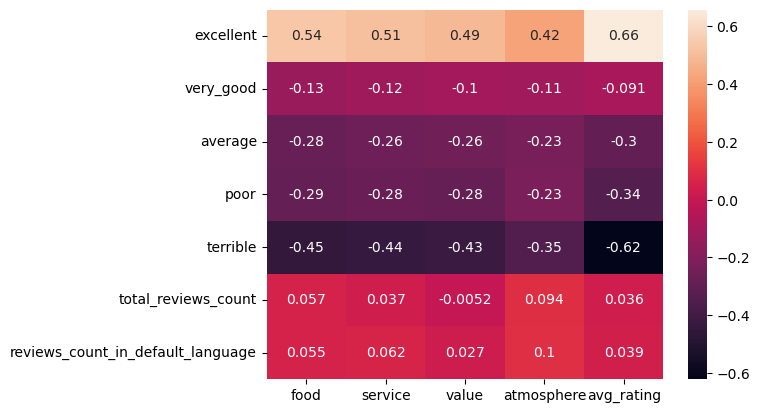

In [38]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(rev_rate_corr_matrix, annot=True)
plt.show()

### As visualized above, now we can see clear correlation between positive comments and ratings. Also, we can see clear negative correlation between negative comments and ratings. The correlation is very high and obvious expecially for extreme grades("excellent" and "terrible"). This indicates that although "very_good" comments may be unrealiable, "excellent" and "terrible" comments seems to be significantly reliable.

### The reviews counts columns are uncorrelated with ratings. It indicates the number of reviews are not directly related to ratings performance. It may indicate some popularity. To understand "reviews_count_in_default_language" effect, we may normalize it in its default language(or a neighboorhood, country,etc) to get some sense of popularity. But this brings the question that popularity measures and review numbers are biased about positive/negative side or it is unbiased and tells nothing about goodness of the restaurant. According to the correlation result, the review count numbers tell nothing about the goodness of the restaurant.

### Now since we normalized the review column grades(excellent","very good", "average","poor","terrible"),we have a proability distribution effectively. Now, we can use this review distribution in order to extract further futures. We can calculate standard statistics such as mean, std(assigning index on pdf values such as 1-5) or entropy-like measures to deduce reliability/variability of comments. When we calculate mean as further feature by assigning values such as (1-5) to review column grades, we should see stronger correlation between "review grades mean" and average rating. 
### Additionally, now entropy can be calculated for each row(in review column grades pdf) and used as an extra review feature. When entropy is high in review pdf, it indicates that either review column grades are unreliable or the restaurant has variance and unstability in service quality(more meaningfully). When we discard entries with higher entropy(as a measure of reliability)(ie entropy>threshold, decided by an entropy histogram on all restaurants), I would expect to see stronger correlation results.

## 2. Vegetarian or Nonvegetarian?

### To compare both, we need to measure its relationship to "avg_rating", "excellent" or/and "terrible" columns and maybe "food". Here, "food" has been thought to be more related with "vegetarian" data than other rating columns(atmosphere, value). We have seen strong correlation between these four columns. Especially, we have induced that "excellent" and "terrible" reviews tell us about goodness of a restaurant more. Therefore, we should see the similar inference of them about vegetarianism.

In [71]:
df_vegetarian = df['vegetarian_friendly'].map({'N': 0, 'Y': 1})#converted to boolean datatype
veg_related_columns = ["avg_rating","food","excellent","terrible"]

#All ratings columns are added just to see vegetarianism is related to athmosphere, value etc
df_veg_related = df_review_normalized_grades[veg_related_columns[-2:]]
print(df_veg_related.shape)
print(df_rating.shape)
df_veg_goodness = pd.concat([df_rating,df_veg_related],axis=1)
print(df_veg_goodness)
temp_df = pd.concat([df_vegetarian, df_veg_goodness], axis=1, keys=['df1', 'df2'])
veg_goodness_corr_matrix = temp_df.corr().loc['df1', 'df2']

(1083397, 2)
(1083397, 5)
         food  service  value  atmosphere  avg_rating  excellent  terrible
0         4.0      4.5    4.0         NaN         4.0   1.000000       0.0
1         NaN      NaN    NaN         NaN         4.0   0.400000       0.0
2         NaN      NaN    NaN         NaN         5.0   0.750000       0.0
3         4.5      4.5    4.5         NaN         4.0   1.000000       0.0
4         4.5      4.5    4.5         NaN         4.5   0.363636       0.0
...       ...      ...    ...         ...         ...        ...       ...
1083392   NaN      NaN    NaN         NaN         2.5   0.000000       1.0
1083393   NaN      NaN    NaN         NaN         2.0   0.000000       0.4
1083394   NaN      NaN    NaN         NaN         3.0   0.500000       0.5
1083395   NaN      NaN    NaN         NaN         NaN        NaN       NaN
1083396   NaN      NaN    NaN         NaN         1.5   0.000000       0.5

[1083397 rows x 7 columns]


                         food   service     value  atmosphere  avg_rating  \
vegetarian_friendly  0.240684  0.220731  0.194673    0.220403    0.137083   

                     excellent  terrible  
vegetarian_friendly     0.1031  -0.11443  


<BarContainer object of 7 artists>

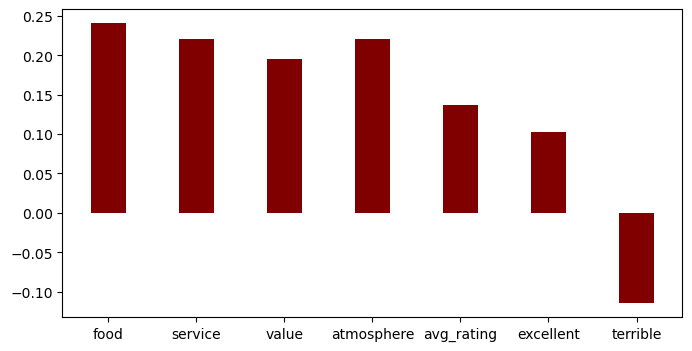

In [70]:
print(veg_goodness_corr_matrix)

fig = plt.figure(figsize = (8, 4))
plt.bar(veg_goodness_corr_matrix.columns,veg_goodness_corr_matrix.iloc[0].values,color ='maroon',width = 0.4)

#sn.heatmap(veg_goodness_corr_matrix, annot=True)
#plt.show()

### We have seen positive correlation between being vegetarian(scalarized as 1) and food, service, value, athmosphere, average rating and "excellent" reviews. Contrarily, we have negative correlation with "terrible" reviews. Hence, generally we can deduce that "vegetarian friendly" restaurants are appreciated more than "non-vegetarian" restaurants. Here, we even see its positive relation with atmosphere and value. I had not though it would be correlated with athmosphere. It indicates that vegetarianism somehow brings more quality or appreciated more by their users. It may be due to vegetarian people may be biased towards vegetarian restaurants. 

### Here I used correlation coefficient untraditionally to measure biasedness of vegetarianism towards goodness and quality. Although, vegetarianism is measured as binary, I believe correlation coefficient can give idea about its biasedness toward goodness(on contrary to its use to measure linear relationship). Traditionally, I would have been expected to calculate average ratings for both vegetarian and non-vegetarian restaurants and compare the 2 class-average rating results to induce goodness of which.  At the end, I will try to calculate and present average ratings for both veg and non-veg restaurants.

In [211]:
veg_avg_rating_mean = df.loc[df['vegetarian_friendly'] == 'Y', 'avg_rating'].mean()
veg_atmosphere_mean = df.loc[df['vegetarian_friendly'] == 'Y', 'atmosphere'].mean()
veg_value_mean = df.loc[df['vegetarian_friendly'] == 'Y', 'value'].mean()
veg_service_mean = df.loc[df['vegetarian_friendly'] == 'Y', 'service'].mean()
veg_excellent_mean  = df_review_normalized_grades.loc[df['vegetarian_friendly'] == 'Y', 'excellent'].mean()
veg_terrible_mean   = df_review_normalized_grades.loc[df['vegetarian_friendly'] == 'Y', 'terrible'].mean()

nonveg_avg_rating_mean = df.loc[df['vegetarian_friendly'] == 'N', 'avg_rating'].mean()
nonveg_atmosphere_mean = df.loc[df['vegetarian_friendly'] == 'N', 'atmosphere'].mean()
nonveg_value_mean = df.loc[df['vegetarian_friendly'] == 'N', 'value'].mean()
nonveg_service_mean = df.loc[df['vegetarian_friendly'] == 'N', 'service'].mean()
nonveg_excellent_mean  = df_review_normalized_grades.loc[df['vegetarian_friendly'] == 'N', 'excellent'].mean()
nonveg_terrible_mean   = df_review_normalized_grades.loc[df['vegetarian_friendly'] == 'N', 'terrible'].mean()

nonveg_means = [nonveg_avg_rating_mean,nonveg_atmosphere_mean,nonveg_value_mean,nonveg_service_mean,nonveg_excellent_mean,nonveg_terrible_mean]
veg_means = [veg_avg_rating_mean,veg_atmosphere_mean,veg_value_mean,veg_service_mean,veg_excellent_mean,veg_terrible_mean]

In [213]:
print(veg_means)
print(nonveg_means)

[4.176085894200317, 4.03232840109904, 4.091916912647548, 4.191907412173466, 0.5692624638443726, 0.04952621647575628]
[3.9676433038453016, 3.781854686181511, 3.8669216624262495, 3.9351944303400614, 0.49715626080146375, 0.08897780257331539]


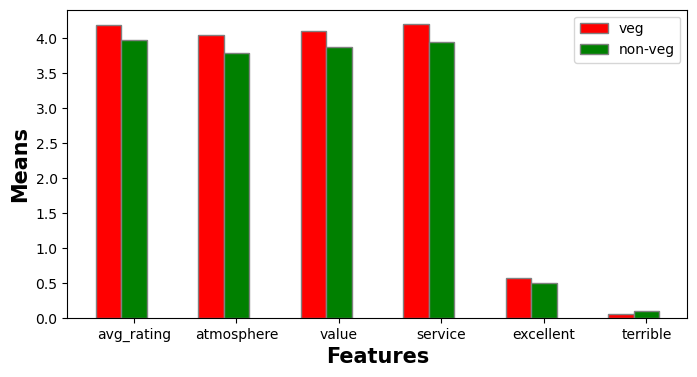

In [217]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 4))
 
# Set position of bar on X axis
br1 = np.arange(len(veg_means))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, veg_means, color ='r', width = barWidth,
        edgecolor ='grey', label ='veg')
plt.bar(br2, nonveg_means, color ='g', width = barWidth,
        edgecolor ='grey', label ='non-veg')
 
# Adding Xticks
plt.xlabel('Features', fontweight ='bold', fontsize = 15)
plt.ylabel('Means', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(veg_means))],
        ['avg_rating', 'atmosphere', 'value', 'service', 'excellent','terrible'])
 
plt.legend()
plt.show()

### Above plots emphasizes our findings from correlation results. Veg performs better in all good measures and worse in bad measure(terrible).

## 3. Are there any significantly more expensive cuisines?

In [154]:
import math
import re

df_prices = df[["price_level","price_range"]]
#print(df_prices["price_range"].iloc[-30:-1])
average_prices = []
low_prices  = []
high_prices = []
for i in range(df_prices.shape[0]):
    temp = df_prices["price_range"][i]
    if isinstance(temp, float):
        pass
        low_prices.append(temp)
        average_prices.append(temp)
        high_prices.append(temp)
    else:
        index_middle = temp.find("-")
        #Calculate Low Price
        low_price  = int(re.search(r'\d+', temp[:index_middle]).group())
        #print(temp)
        #high_price = int(temp[index_middle+2:])
        
        #Calculate High Price
        high_string = temp[index_middle+1:]
        if "," in high_string:
            high_string = high_string.replace(',','')  
        high_price = int(re.search(r'\d+', high_string).group())
        
        #Calculate Average Price
        average_price = (high_price + low_price)/2
        
        #Append Prices Information taken as Int and NaN
        low_prices.append(low_price)
        high_prices.append(high_price)
        average_prices.append(average_price)


In [148]:
#Example with a Very High Price but Mid-Range Restaurant
df.iloc[38880]

restaurant_link                                                      g187147-d10270975
restaurant_name                                                                 Nagoya
original_location                       ["Europe", "France", "Ile-de-France", "Paris"]
country                                                                         France
region                                                                   Ile-de-France
province                                                                           NaN
city                                                                             Paris
address                               58 boulevard du Montparnasse, 75015 Paris France
latitude                                                                     48.844284
longitude                                                                     2.322058
claimed                                                                        Claimed
awards                               Travel

When checking and calculating prices, I observed incredibly high prices such as 9,999,999 as in the entry(38880). I checked the restaurant it does not seem correct. But I am not sure since some wine and champagne prices could be high.

In [157]:
df_prices_int = pd.DataFrame(list(zip(low_prices, high_prices, average_prices)),
               columns =['low_prices', 'high_prices','average_prices'])
print(df_prices_int[:10])

   low_prices  high_prices  average_prices
0         NaN          NaN             NaN
1         NaN          NaN             NaN
2         NaN          NaN             NaN
3         NaN          NaN             NaN
4         NaN          NaN             NaN
5        14.0         29.0            21.5
6         8.0         17.0            12.5
7        10.0         35.0            22.5
8        12.0         26.0            19.0
9        12.0         30.0            21.0


(97742,)
Number of cuisines with 1 counts: 0 among 97742
[53243 39103 35009 27339 26998 14323 13803 13703 13440 13244 11380 10858
  9904  8902  8455  7760  7089  6468  6200  6124  6111  6044  5658  5552
  5533  5437  4681  4447  4295  4182  4138  4031  3716  3612  3470  3459
  3342  3296  3261  3174  3161  3122  3071  2882  2812  2705  2653  2617
  2586  2429  2356  2227  2211  2165  2018  1861  1796  1777  1757  1636
  1629  1615  1516  1487  1465  1458  1450  1449  1432  1396  1339  1306
  1306  1271  1258  1256  1254  1209  1209  1164  1155  1138  1117  1099
  1054  1049  1047  1043  1042  1039  1038  1020  1015  1010  1005]


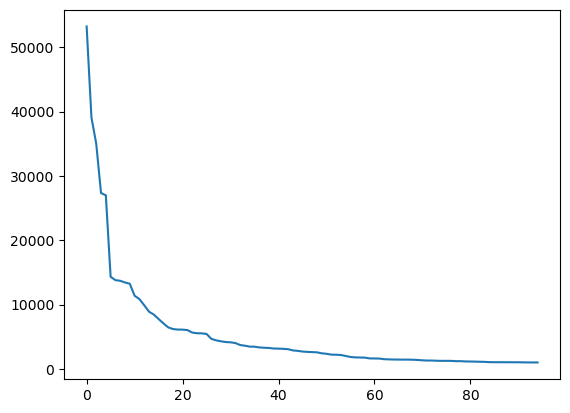

In [227]:
## DATA LENGTH FOR EACH STOCKS
cuisines_names  = df.cuisines.unique()
num_cuisines = cuisines_names.size
cuisines_val_counts = df["cuisines"].value_counts()
cuisines_index  = cuisines_val_counts.index
cuisines_counts = cuisines_val_counts.values
num_cuisines_one = sum(cuisines_counts<1)
print("Number of cuisines with 1 counts:",num_cuisines_one,"among",num_cuisines)
print(cuisines_counts[cuisines_counts>1000])
plt.plot(cuisines_counts[cuisines_counts>1000])

In [260]:
print(cuisines_index.values[:50])
print(cuisines_counts[:50])

['Italian' 'French' 'Cafe' 'Spanish' 'Italian, Pizza' 'French, European'
 'Fast food' 'Bar, British, Pub' 'Pizza' 'German' 'Cafe, British'
 'Mediterranean, Spanish' 'Bar, Pub' 'Greek' 'British'
 'Italian, Mediterranean' 'Chinese' 'Italian, Seafood, Mediterranean'
 'Indian' 'European' 'European, Portuguese' 'Chinese, Asian'
 'Mediterranean' 'Spanish, Mediterranean' 'Pizza, Italian'
 'Italian, Pizza, Mediterranean' 'American' 'Dutch, European'
 'International' 'Mediterranean, European, Spanish'
 'Japanese, Sushi, Asian' 'Polish, European'
 'Italian, Pizza, Seafood, Mediterranean' 'Pub' 'Austrian, European'
 'Italian, Pizza, Mediterranean, European' 'Belgian, European'
 'Italian, Cafe' 'Italian, Seafood' 'Portuguese, European'
 'Mediterranean, Greek' 'German, European, Central European' 'Turkish'
 'American, Fast food' 'Italian, Mediterranean, European' 'Asian, Thai'
 'Seafood' 'Italian, Pizza, European' 'Pizza, Fast food'
 'Italian, European']
[53243 39103 35009 27339 26998 14323 13803 1

The cuisine entry has very few and specific labels. Many of different cuisine types has very few samples. Hence, it is hard to interpret a cuisine is more expensive.

In [4]:
cuisine_high_prices_means    = []
cuisine_low_prices_means     = []
cuisine_average_prices_means = []
calculated_cuisines = []
cuisine_index       = []

counter = 0
for cuisine_name in cuisines_index.values:
    #print(cuisines_val_counts.loc[cuisine_name])
    if cuisines_val_counts.loc[cuisine_name]>1000:
        cuisine_low_prices_means.append(df_prices_int.loc[df['cuisines'] == cuisine_name, 'low_prices'].median())
        cuisine_high_prices_means.append(df_prices_int.loc[df['cuisines'] == cuisine_name, 'high_prices'].median())
        cuisine_average_prices_means.append(df_prices_int.loc[df['cuisines'] == cuisine_name, 'average_prices'].median())
        calculated_cuisines.append(cuisine_name)
        cuisine_index.append(counter)
    counter += 1
    

NameError: name 'cuisines_index' is not defined

### Since there are suspicious entries that disrupts the mean prices(such as ~1,000,000). I have used median values for the mostly observed cuisines. Since, we have enough data, we can get more robust measure of average prices by median(ie eliminating suspicious or extremey values). I only calculated for the cuisines with >1000 entries mainly due to processing time limitation.

Maximum Average Priced Cuisine is: Italian, Seafood, Mediterranean, European
[17 74 86 94]
More expensive cuisines(Upper 5%) are:
 ['Italian, Seafood, Mediterranean'
 'Italian, Seafood, Mediterranean, European' 'European, British'
 'Seafood, Mediterranean, European, Spanish']


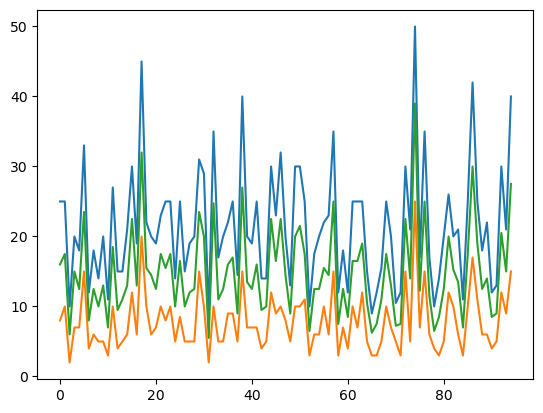

In [308]:
plt.plot(cuisine_high_prices_means)
plt.plot(cuisine_low_prices_means)
plt.plot(cuisine_average_prices_means)

mean_median_high = np.mean(cuisine_high_prices_means)
mean_median_low = np.mean(cuisine_low_prices_means)
mean_median_average = np.mean(cuisine_average_prices_means)

std_median_high = np.std(cuisine_high_prices_means)
std_median_low = np.std(cuisine_low_prices_means)
std_median_average = np.std(cuisine_average_prices_means)

max_index = pd.Series(cuisine_average_prices_means).idxmax()
print("Maximum Average Priced Cuisine is:",calculated_cuisines[max_index])
#print(cuisines_index.values[cuisine_index[max_index]])

expensive_index = np.asarray(np.argwhere(cuisine_average_prices_means > mean_median_average + 2 * std_median_average)).reshape((-1,)).T

#Within 5% std around mean:95% confidence interval
print(expensive_index)
print("More expensive cuisines(Upper 5%) are:\n", np.array(calculated_cuisines)[expensive_index])

### According to my analysis, the most expensive cuisines are:
* 'Italian, Seafood, Mediterranean'
* 'Italian, Seafood, Mediterranean, European' 
* 'European, British'
* 'Seafood, Mediterranean, European, Spanish'

### We observe that more common cuisine definitions are: "Seafood, Mediterranean", "European", "Italian, Seafood, Mediterranean", "Seafood, Mediterranean, European" 

# Business Specific

In [341]:
business_dataset_path = os.path.join(assets_path,"europe_capitals_population_and_area.csv")
#Since I cannot preidentify the column dtypes, I use low_memory=False or engine=python and preferred engine='python'
#df = pd.read_csv(dataset_path,low_memory=False)
column_names = ['CityNo','City','Country','Population','Area','num_gluten_free_restaurants']
df_business = pd.read_csv(business_dataset_path,sep="[;|,]",engine='python',names=column_names, skiprows=1)

In [347]:
#Visualize the Dataset
print(df_business)

    CityNo        City      Country  Population  Area  \
0        1   Amsterdam   Netherland      851573   219   
1        2      Athens       Greece      664046  2929   
2        4   Barcelona        Spain     1620809   101   
3        4      Berlin      Germany     3711930   891   
4        5  Bratislava     Slovakia      424428   367   
5        6    Brussels      Belgium     1191604   161   
6        7    Budapest      Hungary     1779361   525   
7        8  Copenhagen      Denmark      602481    88   
8        9      Dublin      Ireland      527612   115   
9       10   Edinburgh     Scotland      482005   264   
10      11      Geneva  Switzerland      198979    15   
11      12     Hamburg      Germany     1822445   755   
12      13    Helsinki      Finland      631695   184   
13      14      Krakow       Poland      765320   327   
14      15      Lisbon     Portugal      504718   100   
15      16   Ljubljana     Slovenia      279631   163   
16      17      London      Eng

Since, we have measure population and number of restaurants in the same area and assumed uniform distribution, I decided to just use population per restaurant measure. Now, if we open a restaurant we need to figure out how much population are we gonna get?
I think missing values are unknown values and I do not calculate for them. I increased number of restaurants by 1(considering we are gonna open) and calculate how much population are we gonna get in that situation? Furthermore, if the number of restaurant is really few, how are we gonna get if another one opens after us? Is it changing too much indicating riskyness?

In [374]:
df_pop_per_rest_before = df_business[column_names[3]].divide(df_business[column_names[-1]]+1,axis=0)
df_pop_per_rest_after = df_business[column_names[3]].divide(df_business[column_names[-1]]+2,axis=0)
df_pop_per_rest_change_ratio = df_pop_per_rest_after.divide(df_pop_per_rest_before,axis=0)

temp = pd.concat([df_pop_per_rest_before,df_pop_per_rest_after,df_pop_per_rest_change_ratio],axis=1)
temp.columns=["pop_per_before","pop_per_after","pop_per_ratio"]
print(temp)

    pop_per_before  pop_per_after  pop_per_ratio
0     25805.242424   25046.264706       0.970588
1              NaN            NaN            NaN
2    324161.800000  270134.833333       0.833333
3    463991.250000  412436.666667       0.888889
4     60632.571429   53053.500000       0.875000
5     30553.948718   29790.100000       0.975000
6    593120.333333  444840.250000       0.750000
7     23172.346154   22314.111111       0.962963
8              NaN            NaN            NaN
9              NaN            NaN            NaN
10     2139.559140    2116.797872       0.989362
11             NaN            NaN            NaN
12   105282.500000   90242.142857       0.857143
13             NaN            NaN            NaN
14             NaN            NaN            NaN
15    31070.111111   27963.100000       0.900000
16             NaN            NaN            NaN
17   118133.400000   98444.500000       0.833333
18     5756.988636    5692.303371       0.988764
19   785497.750000  

In [399]:
new_temp1 = temp.nlargest(5, ['pop_per_before'])
new_temp2  = temp.nlargest(5, ['pop_per_ratio'])

max_5_index_pop_per_rest = new_temp1.index.values
max_5_index_pop_per_ratio = new_temp2.index.values

ratios = temp["pop_per_ratio"]
valued_index = np.asarray(np.where(temp["pop_per_before"].isna()==0)).reshape((-1,)).T

#Assume 4 years period
N=4
pop_per_ratio_future = np.zeros((valued_index.shape[0],N+1))
pop_per_ratio_future[:,0] = temp["pop_per_before"].iloc[valued_index].values
for k in range(N):
    pop_per_ratio_future[:,k+1] = pop_per_ratio_future[:,k] * ratios.values[valued_index]

In [409]:
print(df_business[column_names[1]].iloc[max_5_index_pop_per_rest].values)

['Madrid' 'Budapest' 'Berlin' 'Paris' 'Barcelona']


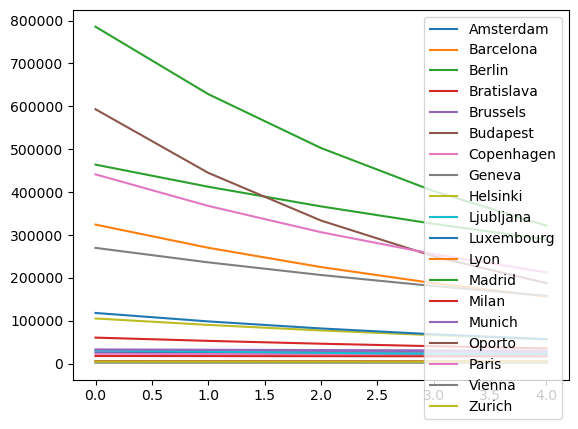

In [406]:
plt.plot(pop_per_ratio_future.T)
plt.legend(df_business[column_names[1]].iloc[valued_index].values,loc="upper right")
plt.show()

### 1. According to results, the best places to open a new gluten-free restaurant are: ['Madrid','Budapest' 'Berlin' 'Paris' 'Barcelona']. However, for long term purposes, due to decreasing pop. per restaurant ratio "Geneva" would have replaced "Barcelona".

### 2. As a further future population density can be calculated using population and area features. We divide population by area to calculate population density. We can also measure number of restaurant density per area to use further by dividing number of restaurants by area.

# Bonus

In [424]:
import json

bonus_dataset_path = os.path.join(assets_path,"paris_bounding_polygon.json")
f = open(bonus_dataset_path)
  
# returns JSON object as 
# a dictionary
data = json.load(f)
data_np = np.asarray(data)

[[ 2.2241686 48.8534419]
 [ 2.2241606 48.8534778]
 [ 2.2241429 48.8535779]
 ...
 [ 2.2263608 48.8529593]
 [ 2.2255595 48.8531357]
 [ 2.2241686 48.8534419]]
<built-in method index of list object at 0x000001CD46A19308>


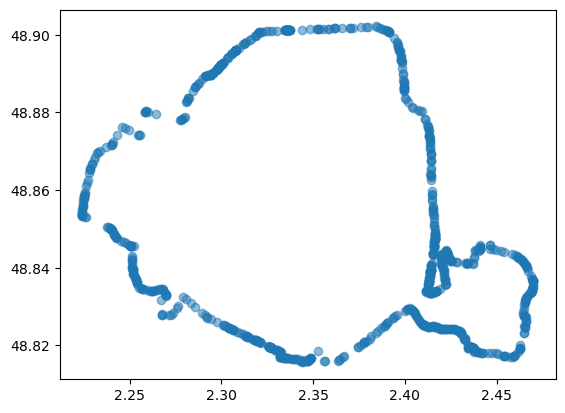

In [496]:
#Visualize the Data
long = data_np[:,0]
lat  = data_np[:,1]

mean_lat  = mean(lat)
mean_long = mean(long)

plt.scatter(long, lat, alpha=0.5)
plt.show()

## Algorithm Suggestion 1
### Circular Hough Transform Like Algorithm
### Circular or differently shaped version of classical Hough transform algorithm to measure and detect lines. 
### 1. We pick a random point and create a random circle around the point, then estimate the restaurant density in that point.
### 2. By that way we randomly create an elliptical, circular or square/tetragonal/polygonal shapes(l1-norm ball, l-inf norm ball), and estimate the restaurant population density for each circular. Now at the end, we have N sized ($\theta$, $R$, density) tensor.
### 3. We pick maximum density and decide as $\theta_{opt},radius_{opt}$ as best location and region. 
### 4. If we do not pick directly maximum density, we can pick maximum k density regions and average or further iterate the process with finer search.

## Algorithm Suggestion 2
### 1. We pick a random point in the area and takes a neighborhood with a distance parameter(euclidean(circular), minkowski-like distance(square), linf, l1 norm balls(tetragonal neighborhoods etc)). 
### 2. In the neighborhood, calculate the relative angle and distance to each neighbor point(taken from distance vector). At this point we have $N$ sized(number of neighbors) $\theta$ vector (0,360) and $dist$ vector. Or we have $N \times (\theta,dist)$ values.
### 3. We would want to pull away from closest directions. So, we need to use a function to create negative cost with closeness. Since, we interpolate the cost function for example around some aggreated points about some theta values, we would want to get away from dense neighbors from a point. Hence, we should create a cost function monotonically decreasing with distance. Here, I propose an exponential negative logarithm of distance such as: 
$$ C_i(\theta) = exp(-log(distance_i)) $$
### Now we have a discrete cost function indexed with angles $\theta$. However, it has very ups and downs for different angles(depends on closedness of neighbor of that angle). It has a high frequency discrete vector(with not equal indexes. We need to smooth the cost function by Low-Pass-Filtering. Since, it has not equally spaced theta values, we should apply a continous circular convolution(since thetas are from 0-2pi, ie circular shaped). However, since it is not possible, we need to first get a meaningful discrete cost vector. I propose we divide the theta indices to M equally spaced intervals and integrate the cost functions existed for that interval:
$$ C_k = \sum C_{\theta_k} $$

### Now we should have a M sized discrete vector. In order to fit a function, we need to smooth the discrete vector by applying circular convolution(ie circular averaging may be [1/4, 1/2, 1/4]). Now, we have a discrete cost function representing a beam contour shaped as the image below:
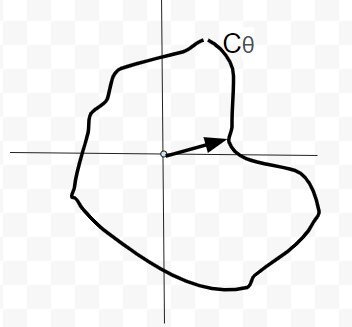

### 4. We need to go from origin towards the nearest point(lower cost function). Hence, we pick the lowest index value of our discrete cost vector and go towards the corresponding theta by a step size:

$$ x_{t+1} = x_t + \alpha \times cos(\theta_{closest}) $$
$$ y_{t+1} = y_t + \alpha \times sin(\theta_{closest}) $$

### 5. At this point, we should check if we have converged or directly observe the iteration contour and terminate the algorithm manually. 
### If converged        ==> terminate the algorithm
### If not converged  ==> go to Step 2

### To start implementation, I will try to find if an Italian restaurant is in Paris neighborhood. Since, we have a data with (lat, long) information, we can use the previous dataframe if a restaurant is in Paris. We can use a convex hull algorithm to geometricall and efficiently represent the boundary of Paris as a convex hull. Then, we need to check if a point is in the convex hull. If an Italian restaurant is in the convex hull, then we can add it to our Paris-Italian dataset. If do not have time, I can directly try to use City data in the original dataframe.

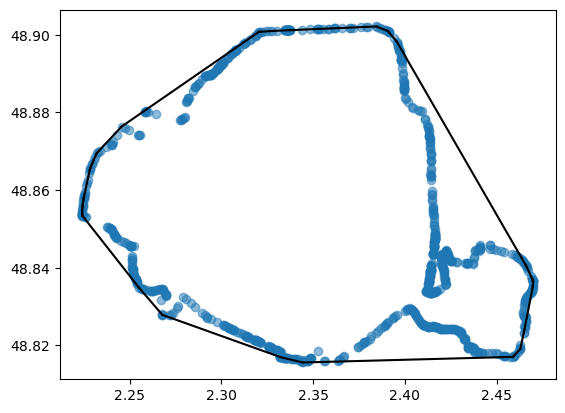

In [527]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

paris_cvx_hull = ConvexHull(data_np)
for simplex in paris_cvx_hull.simplices:
    plt.plot(data_np[simplex, 0], data_np[simplex, 1], 'k-')
    
plt.scatter(long,lat,alpha=0.5)
plt.show()

In [577]:
#Reference: https://salzi.blog/2014/05/01/convex-hull-how-to-tell-whether-a-point-is-inside-or-outside/
#Adapted and Changed From Reference
def cross(point_o, point_a, point_b):
    p = point_a[0] * (point_b[1] - point_o[1]) + point_b[0] * (point_o[1] - point_a[1]) + point_o[0] * (point_a[1] - point_b[1])

    #temp = (point_a[0] - point_o[0]) * (point_b[1] - point_o[1]) - (
     #       point_a[1] - point_o[1]) * (point_b[0] - point_o[0])

    return p

def point_is_inside_cvx_hull(convex_hull, point):
    for simplex in convex_hull.simplices:
        hull_point1 = data_np[simplex[0],:]
        hull_point2 = data_np[simplex[1],:]
        if cross(hull_point1, hull_point2, point ) < 0:
             return False
    return True

def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

def isInHull(P,hull):
    '''
    Datermine if the list of points P lies inside the hull
    :return: list
    List of boolean where true means that the point is inside the convex hull
    '''
    A = hull.equations[:,0:-1]
    b = np.transpose(np.array([hull.equations[:,-1]]))
    
    isInHull = np.all((A @ np.transpose(P)) <= np.tile(-b,(1,len(P))),axis=0)

In [551]:
print(paris_cvx_hull)

In [587]:
from matplotlib.path import Path
hull_path = Path(data_np[paris_cvx_hull.vertices])
for k in range(data_np.shape[0]):
    print(hull_path.contains_point(data_np[k,:]))
    #print(in_hull(data_np[k,:],paris_cvx_hull))
          
#All of values are True. Then finding convex hull algorithm works

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [588]:
Italian_index = np.array(df.index[df['cuisines'] == "Italian"].tolist())
Paris_Italian_lat  = []
Paris_Italian_long = []

for i in Italian_index:
    temp = df.iloc[i][["longitude","latitude"]].astype(float).values
    if np.isnan(temp).any():
        pass
    else:
        if hull_path.contains_point(temp)==True:
            Paris_Italian_long.append(temp[0])
            Paris_Italian_lat.append(temp[1])

In [513]:
print(df.iloc[50])

restaurant_link                                                      g1005948-d5986578
restaurant_name                                            Ristorante Hotel Gran Scala
original_location                    ["Europe", "France", "Auvergne-Rhone-Alpes", "...
country                                                                         France
region                                                            Auvergne-Rhone-Alpes
province                                                                        Savoie
city                                                            Lanslebourg Mont Cenis
address                              73480 Lanslebourg-Mont-Cenis, 73480 Lanslebour...
latitude                                                                      45.28527
longitude                                                                      6.87886
claimed                                                                        Claimed
awards                                     

In [590]:
print("Number of Italian Restaurants in Paris:", len(Paris_Italian_lat))

Number of Italian Restaurants in Paris: 468


### We see that there are 468 Italian cuisine restaurants located in Paris. Now I like to visualize the places inside the Paris cvx hull

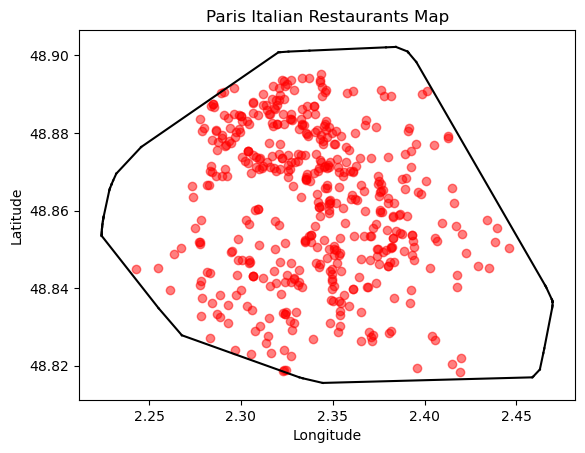

In [595]:
for simplex in paris_cvx_hull.simplices:
    plt.plot(data_np[simplex, 0], data_np[simplex, 1], 'k-')
plt.scatter(Paris_Italian_long, Paris_Italian_lat, alpha=0.5, color ='r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Paris Italian Restaurants Map')
plt.show()

## Circular Hough Transform Based Algorithm

In [624]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

It will be better to change the data as an image matrix in order to save time and directly use Hough Transform libraries. We can directly save and use the scatter plot further load it but harder to match the indices.

In [699]:
min_long = 2.24
max_long = 2.46
min_lat  = 48.8
max_lat  = 48.9

image_size   = 120
long_indices = np.linspace(min_long,max_long,image_size)
delta_long   = (max_long-min_long)/(image_size-1)
lat_indices  = np.linspace(min_lat,max_lat,image_size)
delta_lat    = (max_lat-min_lat)/(image_size-1)

rest_image = np.zeros((image_size,image_size))

Paris_Italian_long_np = np.asarray(Paris_Italian_long)
Paris_Italian_lat_np  = np.asarray(Paris_Italian_lat)

for k in range(Paris_Italian_long_np.shape[0]):
    temp_lat  = Paris_Italian_lat_np[k]
    temp_long = Paris_Italian_long_np[k]
    long_pixel_no = int((temp_long-min_long)/delta_long)
    lat_pixel_no  = int((temp_lat-min_lat)/delta_lat)
    
    #brush the pixel located on (long_pixel_no,lat_pixel_no)
    rest_image [long_pixel_no,lat_pixel_no] = 1

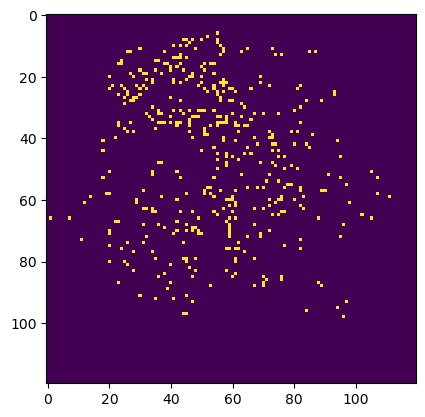

In [703]:
#Display and Check to See The Created Image Is Correct
plt.imshow(np.flipud(rest_image.T))

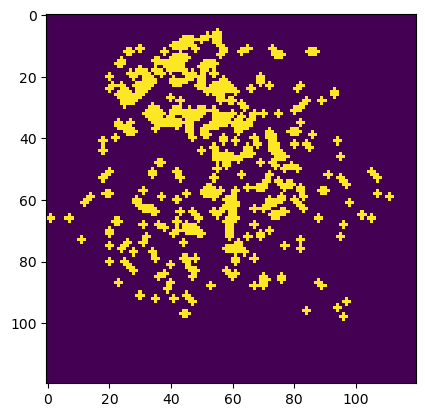

In [742]:
from scipy import ndimage as ndi
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

binarization_threshold = 0.1
#Set Hough Circle Parameters
#hough_radius = np.linspace(0.1, 0.2, 10)
#delta_radius = math.sqrt(delta_lat**2+delta_long**2)
#hough_radii = hough_radius/(math.sqrt(delta_lat**2+delta_long**2))
#print(hough_radii)
hough_radii = np.linspace(5, 10, 10)
#We have an already binary image can use the raw version but I further smoothed and binarized
rest_image_smoothed  = ndi.gaussian_filter(rest_image, 0.8)
rest_image_binarized = rest_image_smoothed > binarization_threshold
plt.imshow(np.flipud(rest_image_binarized.T))

In [748]:
select_k = 5
hough_res = hough_circle(rest_image_binarized, hough_radii)
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii)

#Select the most prominent 2 circles
#Contrarily to the ordinary use we should peak least number of accumulated elements
least_index = np.argsort(accums)[:select_k]
best_x = cx[least_index]
best_y = cy[least_index]
best_radius = radii[least_index]

print(best_x)
best_longs = best_x*delta_long+min_long
best_lats  = best_y*delta_lat+min_lat
best_coordinates = np.stack((best_longs,best_lats),axis=0).T
print("Best longitudes are:",best_longs)
print("Best latitudes are:", best_lats)
print("Best coordinates are:",best_coordinates)

[0.39285714 0.39285714 0.39285714 0.39285714 0.39285714]
[49 41 67 75 43]
Best longitudes are: [2.33058824 2.31579832 2.36386555 2.37865546 2.3194958 ]
Best latitudes are: [48.82436975 48.83277311 48.84537815 48.83361345 48.83445378]
Best coordinates are: [[ 2.33058824 48.82436975]
 [ 2.31579832 48.83277311]
 [ 2.36386555 48.84537815]
 [ 2.37865546 48.83361345]
 [ 2.3194958  48.83445378]]


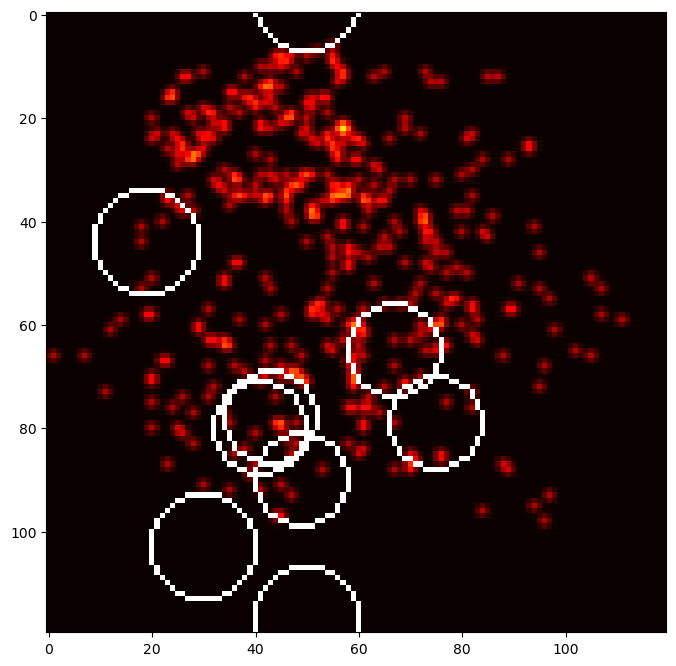

In [747]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 18))
for center_y, center_x, radius in zip(best_x, best_y, best_radius):
    circy, circx = circle_perimeter(int(center_y), int(center_x), int(radius))
    rest_image_smoothed[circy, circx] = 1

ax.imshow(np.flipud(rest_image_smoothed.T), cmap=plt.cm.hot)
plt.show()

### The results are not very good. There may be an issue with the ready to use hough transform class and circle perimeter visualization class

### Now we check the points are really in the Paris region

In [750]:
for k in range(select_k):
    temp = best_coordinates[k,:]
    if hull_path.contains_point(temp):
        print(temp,"coordinate are in Paris")

[ 2.33058824 48.82436975] coordinate are in Paris
[ 2.31579832 48.83277311] coordinate are in Paris
[ 2.36386555 48.84537815] coordinate are in Paris
[ 2.37865546 48.83361345] coordinate are in Paris
[ 2.3194958  48.83445378] coordinate are in Paris


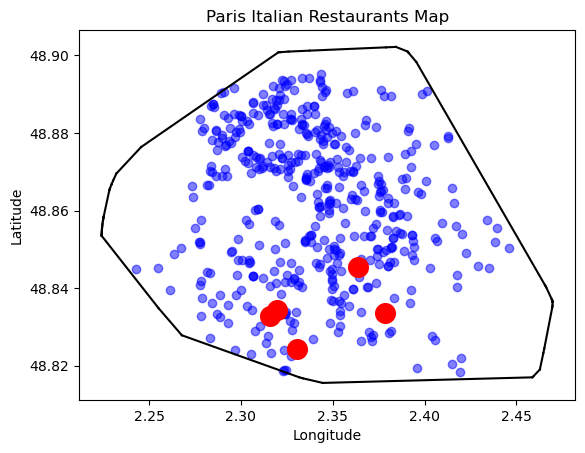

In [756]:
for simplex in paris_cvx_hull.simplices:
    plt.plot(data_np[simplex, 0], data_np[simplex, 1], 'k-')
    
plt.scatter(Paris_Italian_long, Paris_Italian_lat, alpha=0.5, color ='b')
plt.scatter(best_longs, best_lats, alpha=1, color ='r',s=200)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Paris Italian Restaurants Map')
plt.show()